# SNN with IF-Neurons

This code is designed to demo a Spiking Neural Network propogating spikes between simple Integrate-and-Fire (IF) neurons.
All parameters are integer only (to enable a simpler hardware implementation).
Information is encoded with the Time-To-First-Spike (TTFS) scheme: information is encoded in the time that has passed between the arrival of a stimulus and the emission of the spike. A high activation is encoded as an earlier spike transmission and vice versa. Therefore, a high activation value is represented by the inverse TTFS.

Note that the decoded values have a limeted accuracy due to the integer representation.

There is no learning involved at this point.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### IF Neuron model

In [48]:
class IFNeuron():
    def __init__(self):        
        
        # neuron state variables
        self.Vm        = []               # Neuron potential over time 
        self.spikes    = []               # Output spikes of the neuron
        self.slope     = 0                # membrane potential slope
        self.refrac    = 0                # timer to keep track of refrac time
        self.idle      = True             # is neuron idle
        self.encoding  = False            # is neuron encoding info
        
        # additional variables for plotting
        self.time      = []               # Time steps (keeping track of time for plotting)
        self.decoded   = []               # decoded inverse ttfs values
        self.accuracy  = []               # accuracy of decoded value
        self.enc_start = []               # start time of encoding window (for plotting)
        self.input     = []               # keep track of weighted input spikes (for plotting)
         
        # IF Properties 
        self.t_refrac = 5                 # refractory period
        self.thresh   = 255               # firing threshold
        self.type     = 'Integrate and Fire'
        
        # initalize
        self.Vm.append(0)
        self.time.append(0)
        self.spikes.append(0)
    
    def update(self, synapse_out):       # call to update Neuron
        self.input.append(synapse_out)   # keep track of inputs (for plotting)
        
        Vm_new = 0                       # new membrane potential
        slope_new = 0                    # new slope
        neuron_output = 0                # output of neuron
        
        if not self.idle or synapse_out != 0: # calculate only when things are happening

            if self.Vm[-1] >= self.thresh:   # exceed threshold
                neuron_output = 1            # fire spike
                self.refrac = self.t_refrac  # start refractory timer
                self.encoding = False        # stop encoding window
                self.decoded.append(self.thresh - (self.time[-1] - self.enc_start[-1]) + 1) # decode inverse TTFS

                overshoot = self.Vm[-1] - self.thresh  # calc overshoot to estimate accuracy
                self.accuracy.append((1 - overshoot / self.thresh) * 100) # accuracy is the amount of overshoot in relation to the threshold

            else:                            # subthreshold, fire no spike
                if synapse_out != 0 and self.refrac == 0 and not self.encoding: # spike occured, start encoding window!
                    self.encoding = True                  # start encoding window
                    self.enc_start.append(self.time[-1])  # remember start time of encoding window

                if self.refrac == 0:                      # if not in refractory period,
                    slope_new = synapse_out + self.slope  # update slope of membrane potential
                    Vm_new = self.Vm[-1] + slope_new      # update membrane potential

                else:                                     # if in refractory period, 
                    self.refrac = self.refrac - 1         # update refreactory timer
        
        
        # save all params
        self.spikes.append(neuron_output)
        self.Vm.append(Vm_new)
        self.slope = slope_new
        self.idle = self.Vm[-1] == 0 and self.refrac == 0 and not self.encoding # check if neuron is idle
        self.time.append(self.time[-1] + 1) # update time
        

### Define neural network
- Two neurons in layer 0
- Two neurons in layer 1

with the follwoing architecture:

<img src="graph2.bmp" width="300" style="float: left;"/>


In [70]:
# rerun this to re-initalize the neurons internal state
# neurons on layer 0
neuron0_l0 = IFNeuron()
neuron1_l0 = IFNeuron()

# neurons on layer 1
neuron0_l1 = IFNeuron()
neuron1_l1 = IFNeuron()

# synaptic weights
w0 = 1
w1 = 2
w00 = 5
w01 = 7
w10 = 12
w11 = 4

### Define input spike trains

In [71]:
# input spike trains must have the same length
spikes_0 = [0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # input for neuron 0
spikes_1 = [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1] # input for neuron 1

### Run simulation


In [34]:
# helper function to check if network is idle
def network_is_idle(list_of_neurons):
    is_idle = True
    for neuron in list_of_neurons:
        is_idle = is_idle and neuron.idle
    
    return is_idle

In [72]:
time_step = 0

# loop thru spike input trains and continue looping until the input is fully processed (i.e. all neurons are idle)
while time_step < len(spikes_0) or not network_is_idle([neuron0_l0, neuron1_l0, neuron0_l1, neuron1_l1]):
    
    if time_step < len(spikes_0): # feed input spikes to neurons
        # feed spike trains to the two neurons in layer 0
        neuron0_l0.update(spikes_0[time_step] * w0)
        neuron1_l0.update(spikes_1[time_step] * w1)
    
    else: # feed zero input to neurons 
        neuron0_l0.update(0)
        neuron1_l0.update(0)

    # calc weighted input of the two neurons in layer 1
    input0_l1 = neuron0_l0.spikes[-1] * w00 + neuron1_l0.spikes[-1] * w10
    input1_l1 = neuron0_l0.spikes[-1] * w01 + neuron1_l0.spikes[-1] * w11
    
    # feed the inputs into the neurons of layer 1
    neuron0_l1.update(input0_l1)
    neuron1_l1.update(input1_l1)
    
    time_step = time_step + 1

print(f"simulation took {time_step} time steps")

simulation took 190 time steps


### Plot the results of the simulation
- Note how long encoding windows represent low activations (inverse TTFS)
- Note how high activations have a lower accuracy than low activations. 

The accuracy can be increased by increasing the firing threshold at the cost of a longer simulation time

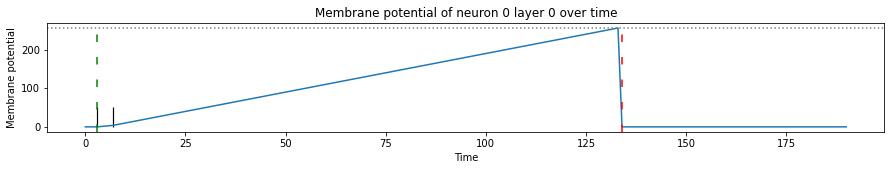

decoded output activations: [126]
decoded output activations: ['0.49'] (relative to the maximum possible activation)
accuracy of decoded values: ['99.61'] %


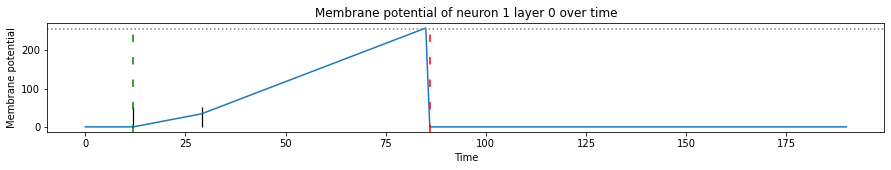

decoded output activations: [183]
decoded output activations: ['0.72'] (relative to the maximum possible activation)
accuracy of decoded values: ['98.82'] %


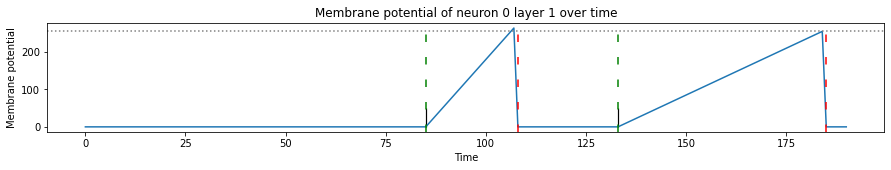

decoded output activations: [234, 205]
decoded output activations: ['0.92', '0.80'] (relative to the maximum possible activation)
accuracy of decoded values: ['96.47', '100.00'] %


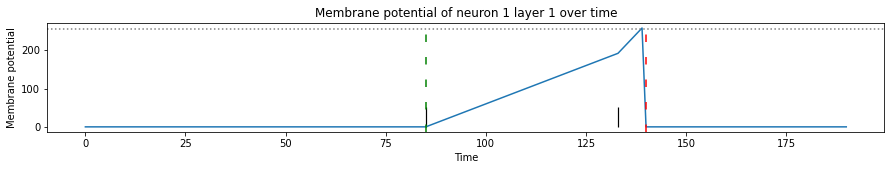

decoded output activations: [202]
decoded output activations: ['0.79'] (relative to the maximum possible activation)
accuracy of decoded values: ['98.82'] %


In [73]:
def plot_neuron(neuron_to_plot, name):
    plt.rcParams['figure.figsize'] = [15, 2]
    plt.ylabel('Membrane potential') 
    plt.xlabel('Time') 
    plt.title(f"Membrane potential of {name} over time")
    
    # plot membrane potential over time (blue)
    plt.plot(neuron_to_plot.time, neuron_to_plot.Vm)
    
    # plot start of encoding window (green)
    for elem in range(len(neuron_to_plot.enc_start)):
        plt.axvline(x=neuron_to_plot.enc_start[elem], color='green', linestyle=(0, (5, 10)))
    
    # plot end of encoding window (red)
    for elem in range(len(neuron_to_plot.spikes)):
        if neuron_to_plot.spikes[elem] != 0:
            plt.axvline(x=neuron_to_plot.time[elem], color='red', linestyle=(0, (5, 10))) 
    
    # plot input spikes (black)
    for elem in range(len(neuron_to_plot.input)):
        if neuron_to_plot.input[elem] > 0:
            plt.vlines(elem, ymin=0, ymax=neuron_to_plot.thresh/5, color='black', linewidth=1.2) # input spikes are all displayed with same size 
    
    # plot threshold (grey)
    plt.axhline(y=neuron_to_plot.thresh, color='grey', linestyle='dotted')
    
    plt.show()
    
    # print decoded activation
    print(f"decoded output activations: {neuron_to_plot.decoded}")
    #[a/b for a,b in zip(neuron_to_plot.decoded,neuron_to_plot.thresh)]
    relative_activations = [a/neuron_to_plot.thresh for a in neuron_to_plot.decoded]
    print(f"decoded output activations: {['%.2f' % elem for elem in relative_activations]} (relative to the maximum possible activation)")
    print(f"accuracy of decoded values: {['%.2f' % elem for elem in neuron_to_plot.accuracy]} %") # display only 2 decimal places

plot_neuron(neuron0_l0, "neuron 0 layer 0")
plot_neuron(neuron1_l0, "neuron 1 layer 0")
plot_neuron(neuron0_l1, "neuron 0 layer 1")
plot_neuron(neuron1_l1, "neuron 1 layer 1")
